In [4]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


def timeit(f):

    def timed(*args, **kw):

        ts = time.time()
        result = f(*args, **kw)
        te = time.time()

        print(f'func: {f.__name__} took: {te-ts:.4f} sec')
        return result

    return timed


def load_dataset(path):
    with open(path, 'rb') as f:
        train_data, test_data = pickle.load(f)
    
    X_train = torch.tensor(train_data[0], dtype=torch.float).unsqueeze(1)
    y_train = torch.tensor(train_data[1], dtype=torch.long)
    X_test = torch.tensor(test_data[0], dtype=torch.float).unsqueeze(1)
    y_test = torch.tensor(test_data[1], dtype=torch.long)
    return X_train, y_train, X_test, y_test


class MnistDataset():
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    

class Trainer:
    
    def __init__(self, model, opt_method, learning_rate, batch_size, epoch, l2):
        self.model = model
        if opt_method == "sgdm":
            self.optimizer = torch.optim.SGD(model.parameters(), learning_rate, momentum=0.9)
        elif opt_method == "adam":
            self.optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=l2)
        else:
            raise NotImplementedError("This optimization is not supported")
        
        self.epoch = epoch
        self.batch_size = batch_size
    
    @timeit
    def train(self, train_data, val_data, early_stop=True, verbose=True, draw_curve=True):
        train_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
        
        train_loss_list, train_acc_list = [], []
        val_loss_list, val_acc_list = [], []
        weights = self.model.state_dict()
        lowest_val_loss = np.inf
        loss_func = nn.CrossEntropyLoss()
        for n in tqdm(range(self.epoch), leave=False):
            self.model.train()
            for X_batch, y_batch in train_loader:
                y_pred = self.model(X_batch)
                batch_loss = loss_func(y_pred, y_batch)
                
                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()
                
            train_loss, train_acc = self.evaluate(train_data)
            train_loss_list.append(train_loss)
            train_acc_list.append(train_acc)
            
            val_loss, val_acc = self.evaluate(val_data)
            val_loss_list.append(val_loss)
            val_acc_list.append(val_acc)
            
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()
            
        if draw_curve:
            x_axis = np.arange(self.epoch)
            fig, axes = plt.subplots(1, 2, figsize=(10, 4))
            axes[0].plot(x_axis, train_loss_list, label="Train")
            axes[0].plot(x_axis, val_loss_list, label="Validation")
            axes[0].set_title("Loss")
            axes[0].legend()
            axes[1].plot(x_axis, train_acc_list, label='Train')
            axes[1].plot(x_axis, val_acc_list, label='Validation')
            axes[1].set_title("Accuracy")
            axes[1].legend()
        
        if early_stop:
            self.model.load_state_dict(weights)
        
        return {
            "train_loss_list": train_loss_list,
            "train_acc_list": train_acc_list,
            "val_loss_list": val_loss_list,
            "val_acc_list": val_acc_list,
        }
    
    def evaluate(self, data, print_acc=False):
        self.model.eval()
        loader = DataLoader(data, batch_size=self.batch_size, shuffle=True)
        loss_func = nn.CrossEntropyLoss()
        acc, loss = 0.0, 0.0
        for X_batch, y_batch in loader:
            with torch.no_grad():
                batch_importance = y_batch.shape[0] / len(data)
                y_pred = self.model(X_batch)
                batch_loss = loss_func(y_pred, y_batch)
                batch_acc = torch.sum(torch.argmax(y_pred, axis=-1) == y_batch) / y_batch.shape[0]
                acc += batch_acc.detach().cpu().item() * batch_importance
                loss += batch_loss.detach().cpu().item() * batch_importance
        if print_acc:
            print(f"Accuracy: {acc:.3f}")
        return loss, acc
    

def KFoldCrossValidation(
    model_class, k, 
    X_train, y_train, X_test, y_test, 
    opt_method='adam', learning_rate=2e-3, batch_size=128, epoch=50, l2=0.0,
    early_break=False,
    **model_args
):
    test_data = MnistDataset(X_test, y_test)
    kf = KFold(n_splits=k, shuffle=True)
    train_acc_list, test_acc_list = [], []
    for i, (train_index, val_index) in enumerate(kf.split(X_train)):
        print(f"Fold {i}:")
        
        train_data = MnistDataset(X_train[train_index], y_train[train_index])
        val_data = MnistDataset(X_train[val_index], y_train[val_index])
        
        model = model_class(**model_args).to(device)
        
        trainer = Trainer(model, opt_method, learning_rate, batch_size, epoch, l2)
        res = trainer.train(train_data, val_data)
        train_acc_best = res['train_acc_list'][np.argmin(res['val_loss_list'])]
        test_loss, test_acc = trainer.evaluate(test_data)
        
        train_acc_list.append(train_acc_best)
        test_acc_list.append(test_acc)
        
        print(f"Training accuracy: {train_acc_best}")
        print(f"Test accuracy: {test_acc}")
        
        if early_break:
            break
    
    if not early_break:
        print("Final results:")
        print(f"Training accuracy: {np.mean(train_acc_list)}+/-{np.std(train_acc_list)}")
        print(f"Test accuracy: {np.mean(test_acc_list)}+/-{np.std(test_acc_list)}")


# Question 1

### For (a) and (b), DO NOT use `torchsummary` package. Please calculate by yourself. 

Output convolution formula: [(Input height - Kernel height + 2 * Padding) / Stride + 1] * # of filters
Down sampling volume formula: W or H = (Input - spatial extent) / stride + 1

## (a)
- (i) (32 - 2 + 2\*0) / 2 + 1 = **16 x 16 x 33**   
- (ii) (16 - 3 + 2\*1) / 1 + 1 = **16 x 16 x 55** 
- (iii) (16 - 3 + 2\*1) / 1 + 1 = 16 x 16 x 77
- After max pooling:
(16 - 2) / 2 + 1 = **8 x 8 x 77**

## (b)
- (i) Still the same.  **16 x 16 x 33**
- (ii) 16 x 16 x 55.  We need to max pool. -> 
- W & H = (16 - 3) / 1 + 1 = 14 x 14
- (ii) = **14 x 14 x 55**
- (iii) (14 - 3 + 2\*1) / 1 + 1 = 14 x 14 x 77 
- Max pooling ->
- (14 - 2) / 2 + 1 = **7 x 7 x 77**


## (c)

### Instructions: For training stability, it is recommened to normalize the data by dividing its max value as you did in HW6.

In [6]:
# Normalize data
X_train, y_train, X_test, y_test = load_dataset("Datasets/mnist.pkl")
X_train /= torch.max(X_train)
X_test /= torch.max(X_test)

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

Fold 0:


func: train took: 54.6507 sec
Training accuracy: 0.9475000000000012
Test accuracy: 0.9478999999999996
Fold 1:


func: train took: 59.4507 sec
Training accuracy: 0.9462250000000018
Test accuracy: 0.9477999999999996
Fold 2:


func: train took: 52.3938 sec
Training accuracy: 0.946400000000001
Test accuracy: 0.9482999999999999
Final results:
Training accuracy: 0.9467083333333347+/-0.000564333431777788
Test accuracy: 0.9479999999999998+/-0.00021602468994705906


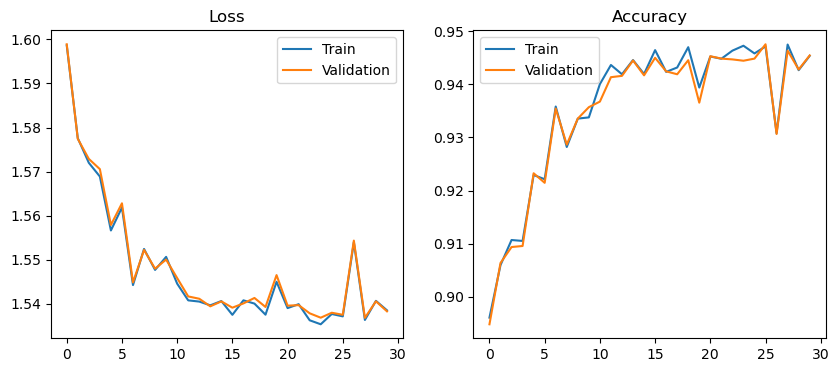

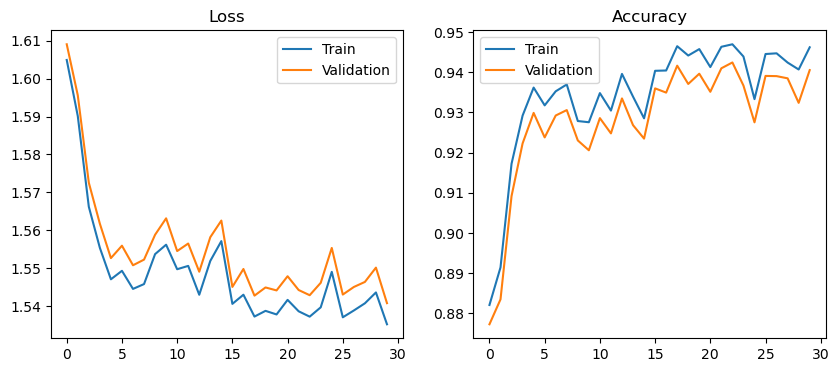

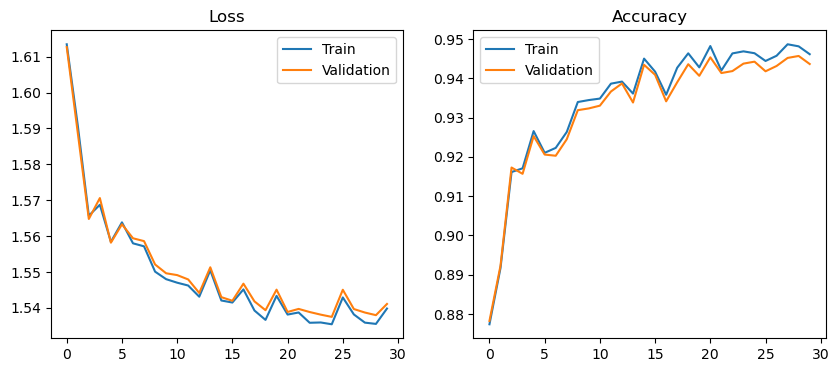

In [15]:
class ShallowCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(1, 3, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            
            nn.Flatten(),

            nn.Linear(3*32*32, 120),
            nn.ReLU(),
            nn.Linear(120, 10),
            nn.Softmax(dim=-1)
        ])
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    

KFoldCrossValidation(ShallowCNN, 3, X_train, y_train, 
                     X_test, y_test, opt_method='adam', learning_rate=1e-3, batch_size=128, epoch=30, l2=0.01)

# (c)
The test accuracy is around 95%.  I did L2 regularization.

## (d)

Fold 0:


  0%|          | 0/30 [00:00<?, ?it/s]

func: train took: 58.7379 sec
Training accuracy: 0.9962749999999989
Test accuracy: 0.9891000000000008
Fold 1:


func: train took: 58.9422 sec
Training accuracy: 0.9961749999999987
Test accuracy: 0.9859999999999999
Fold 2:


func: train took: 58.5846 sec
Training accuracy: 0.9959499999999989
Test accuracy: 0.9865999999999999
Final results:
Training accuracy: 0.9961333333333321+/-0.00013591255358582138
Test accuracy: 0.9872333333333335+/-0.0013424687043738853


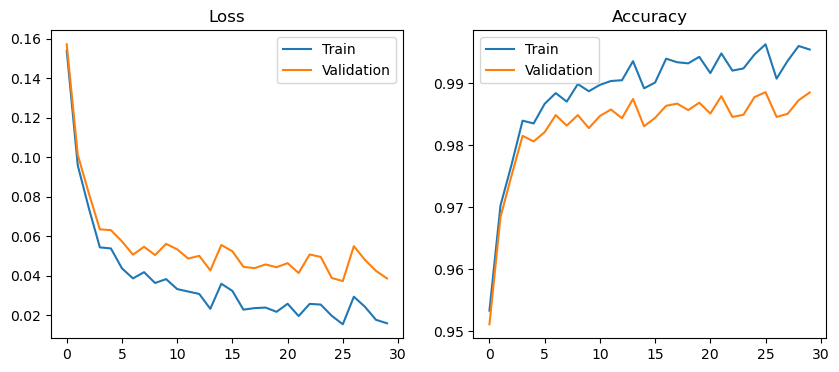

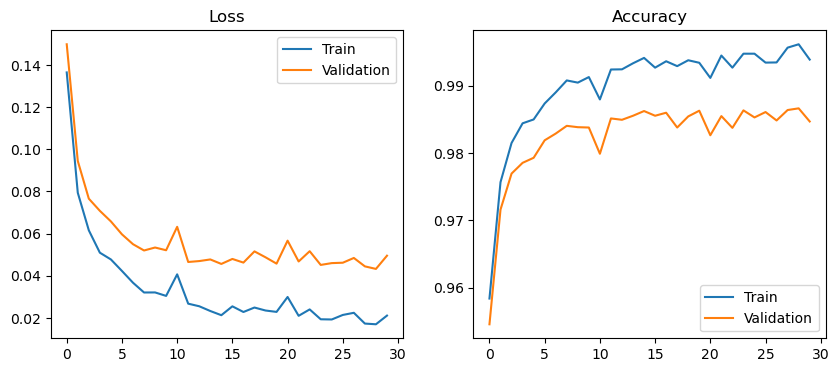

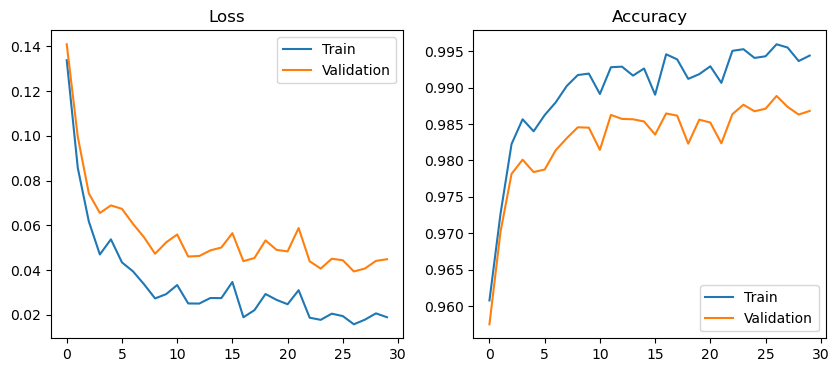

In [14]:
class DeepCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Flatten(),
            
            nn.Linear(32*8*8, 120),
            nn.ReLU(),
            nn.Linear(120, 10),

            nn.Softmax(dim=-1)
        ])
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

KFoldCrossValidation(DeepCNN, 3, X_train, y_train, 
                     X_test, y_test, opt_method='adam', learning_rate=1e-3, batch_size=128, epoch=30, l2=0.001)

# (d)
Deep CNN achieved an accuracy of 98.8%.  I reduced the L2 regularization by a factor of 10.  Then, I added more out_channels and reduced the size of the kernels to 3x3, and less padding.  This helped boost the accuracy.

# Question 2

### Instructions: You can set `early_break=True` in `KFoldCrossValidation` function to just to a train-validation round instead of doing 3-fold.

## (a)


In [25]:
class ResNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(1, 6, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1),

            nn.Conv2d(6, 12, kernel_size=2, stride=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1),
            
            nn.Flatten(),
            
            nn.Linear(300, 300),
            nn.ReLU(),
            nn.Linear(300, 10),

            nn.Softmax(-1)
        ])
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


Fold 0:


func: train took: 67.0088 sec
Training accuracy: 0.1125250000000001
Test accuracy: 0.11350000000000002


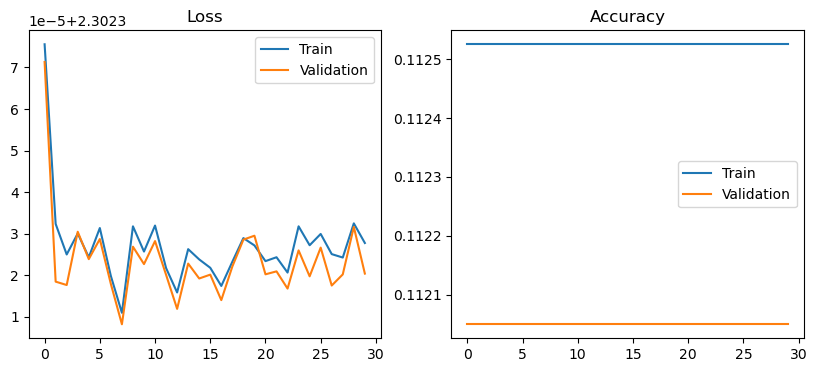

In [26]:
KFoldCrossValidation(ResNN, 3, X_train, y_train, X_test, y_test, learning_rate=1e-3, epoch=30, l2=0.01, early_break=True)

In [27]:
class ResNNBatch(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(1, 6, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1),

            nn.Conv2d(6, 12, kernel_size=2, stride=3, padding=1),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1),
            
            nn.Flatten(),
            nn.Linear(300, 300),
            nn.ReLU(),
            nn.Linear(300, 10),

            nn.Softmax(-1)
        ])
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

Fold 0:


  0%|          | 0/30 [00:00<?, ?it/s]

func: train took: 72.6101 sec
Training accuracy: 0.9681750000000017
Test accuracy: 0.9689999999999996


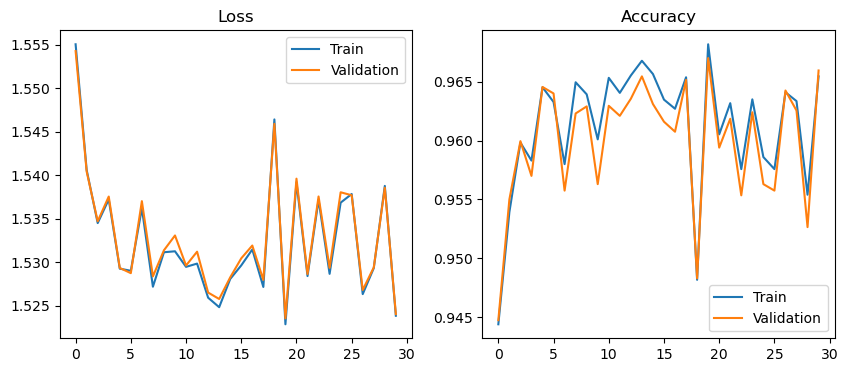

In [28]:
KFoldCrossValidation(ResNNBatch, 3, X_train, y_train, X_test, y_test, learning_rate=1e-3, epoch=30, l2=0.01, early_break=True)

# (a)
Batch normalization is much better. This is expected. A ResNet always needs a batch normalization step.  This is because of the vanishing gradient problem.  By normalizing the activation in each layer by batch, we improve the flow of gradients as we backpropagate.  Also, regularization helps add noise which prevents overfitting.

## (b)

In [7]:
class ResNNBatch_NoSkip(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(1, 6, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1),

            nn.Conv2d(6, 12, kernel_size=2, stride=3, padding=1),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1),
            
            nn.Flatten(),

            nn.Linear(300, 300),
            nn.ReLU(),
            nn.Linear(300, 10),
            
            nn.Softmax(-1)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

Fold 0:


  0%|          | 0/30 [00:00<?, ?it/s]

func: train took: 74.0947 sec
Training accuracy: 0.9649750000000021
Test accuracy: 0.9649999999999995


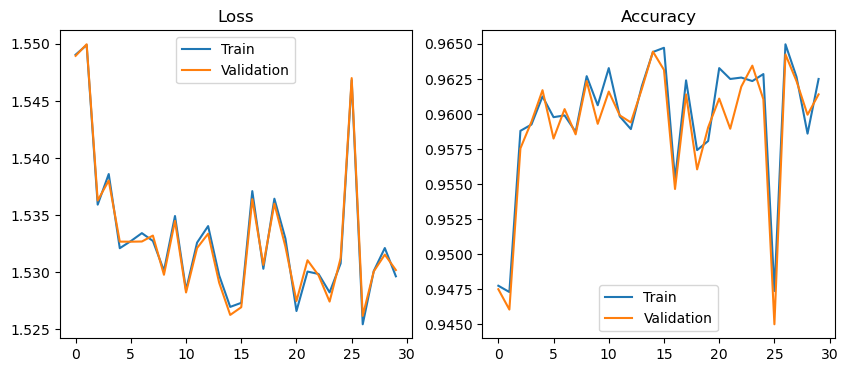

In [12]:
KFoldCrossValidation(ResNNBatch_NoSkip, 3, X_train, y_train, X_test, y_test, 
                     learning_rate=1e-3, epoch=30, l2=0.01, early_break=True)

In [13]:
class ResNNBatch_Skip(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(1, 6, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1),

            nn.Conv2d(6, 12, kernel_size=2, stride=3, padding=1),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1),
            
            nn.Flatten()
        ])
        self.activation = nn.ReLU()
        self.fc = nn.ModuleList([
            nn.Linear(300, 300),
            nn.Linear(300, 10),
        ])
        self.out = nn.Softmax(dim=-1)

    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.activation(x + self.fc[0](x))
        x = self.out(self.fc[1](x))
        return x

Fold 0:


  0%|          | 0/30 [00:00<?, ?it/s]

func: train took: 74.4772 sec
Training accuracy: 0.9694750000000019
Test accuracy: 0.9678999999999991


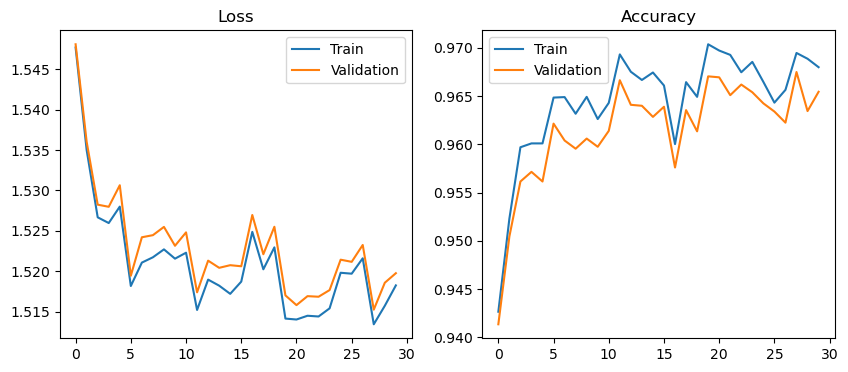

In [14]:
KFoldCrossValidation(ResNNBatch_Skip, 3, X_train, y_train, X_test, y_test, learning_rate=1e-3, epoch=30, l2=0.01, early_break=True)

# (d)
The skip connection was not faster, but it was slightly more accurate, which is expected.  We are hopefully mitigating the problem of vanishing gradient since we have more than 1 convolutional layer.  These skip connections help flow the gradient better so that our backpropagation is not just completely noise once we reach the start of the first convolutional layer again.